In [4]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
df = pd.read_csv("../data/processed/all_shots_only_selected_features-v2.csv", index_col=0)

PLAYERS =['Kobe Bryant', 'LeBron James', 'Stephen Curry', 'Kevin Durant', 'Dwyane Wade', 
        'Dirk Nowitzki', 'Tim Duncan', "Shaquille O'Neal", "Steve Nash", "Kawhi Leonard", 
        "James Harden", "Jason Kidd", "Allen Iverson", "Chris Webber", "Kevin Garnett", 
        "Paul Pierce", "Giannis Antetokounmpo", "Jimmy Butler", "Russell Westbrook", "Dwight Howard"]

In [5]:
X_train = ""
y_train = ""
X_test = ""
y_test = ""
y_pred = ""

def for_player(player=None, year=None):
    global X_test
    global X_train
    global y_test
    global y_train

    if(player):
        df_player = df[df.PLAYER1_NAME==player]
    else:
        df_player = df.copy()

    X = df_player.drop(['target', 'PLAYER1_NAME'], axis=1)
    X = pd.get_dummies(X)
    y = df_player.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    return {
        "Number of finished trials": len(study.trials),
        "Best trial accuracy" : study.best_trial.value,
        "Params": study.best_params,
        "Player": player,
        "Importances": optuna.importance.get_param_importances(study)
    }
    

def objective(trial):
    global X_test
    global X_train
    global y_test
    global y_train
    global y_pred
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        'eval_metric': ['aucpr'],
        'tree_method': "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-10, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-10, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, "validation-aucpr"
    )

    bst = xgb.train(param, train, evals=[(test, "validation")], callbacks=[pruning_callback], verbose_eval=False)

    preds = bst.predict(test)
    y_pred = np.rint(preds)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


In [6]:
# first try with all players
history = for_player()

[I 2024-08-21 18:24:15,109] A new study created in memory with name: no-name-8cdaec38-e6cf-4e32-85e6-c57e9a6c7153
[I 2024-08-21 18:24:16,329] Trial 0 finished with value: 0.5638297872340425 and parameters: {'booster': 'gblinear', 'lambda': 0.008913059818775979, 'alpha': 0.6205290555789721, 'subsample': 0.36885623965105846, 'colsample_bytree': 0.8695249969146048}. Best is trial 0 with value: 0.5638297872340425.
[I 2024-08-21 18:24:21,024] Trial 1 finished with value: 0.5638297872340425 and parameters: {'booster': 'dart', 'lambda': 0.0002664413518421807, 'alpha': 2.749848910032393e-10, 'subsample': 0.45089750972168097, 'colsample_bytree': 0.6386294827958272, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.0008352689256921945, 'gamma': 0.000154892580962473, 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 2.3448025147294755e-08, 'skip_drop': 1.3134423485746084e-07}. Best is trial 0 with value: 0.5638297872340425.
[I 2024-08-21 18:24:23,934] Trial 2 finished with value: 0.6

In [7]:
history['Importances'].values()


dict_values([0.35410864233211253, 0.2620737673933634, 0.23465773917965466, 0.0804487430146728, 0.06871110808019648])

c:\Users\Sarah\anaconda3\envs\nba_env\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


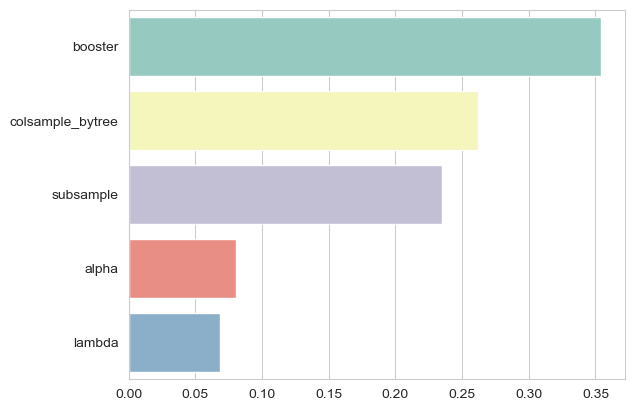

In [8]:
perc =  [float(i) for i in history['Importances'].values()]
sns.barplot(x=perc,y=list(history['Importances'].keys()))
plt.show()

In [9]:
# then test for all players
history = []

for player in PLAYERS:
    history.append(for_player(player))


[I 2024-08-21 18:27:55,470] A new study created in memory with name: no-name-4e415f4c-c81e-4690-ab53-2a781fa646e7
[I 2024-08-21 18:27:55,690] Trial 0 finished with value: 0.5536142031844441 and parameters: {'booster': 'gbtree', 'lambda': 0.19779227443427466, 'alpha': 6.78824571278403e-08, 'subsample': 0.963094311063917, 'colsample_bytree': 0.9954481470802116, 'max_depth': 7, 'min_child_weight': 2, 'eta': 4.386429182244383e-06, 'gamma': 6.020329156386665e-08}. Best is trial 0 with value: 0.5536142031844441.
[I 2024-08-21 18:27:55,791] Trial 1 finished with value: 0.5536142031844441 and parameters: {'booster': 'gblinear', 'lambda': 2.1842120830067995e-10, 'alpha': 0.5682194209724485, 'subsample': 0.6011651816314221, 'colsample_bytree': 0.9410595245281344}. Best is trial 0 with value: 0.5536142031844441.
[I 2024-08-21 18:27:56,023] Trial 2 finished with value: 0.5536142031844441 and parameters: {'booster': 'gbtree', 'lambda': 5.257847264146353e-06, 'alpha': 6.3764905138037125e-09, 'subsam

In [10]:
df_hist = pd.DataFrame.from_dict(history)

In [11]:
df_hist['Best trial accuracy'].mean()

## le résultat est meilleur lorsqu'on prend tous les joueurs

0.6778135569986531